In [44]:
import sys
sys.path.append("../X64")
from Release import SBTimeSeries

'''
For Linux users: replace what is above by
sys.path.append("../build")
import SBTimeSeries
'''

import time
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from datetime import date
from scipy.stats import ks_2samp, kstest, kurtosis
import yfinance as yf
yf.pdr_override()
from fbm import FBM
from tensorflow.keras.datasets import mnist
from pathlib import Path
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
def simulateSB(N, M, Data, deltati, H, nbStepsPerDeltati, numberOfSamples):
    
    """
    @params:
    - N: integer, number of time steps
    - M: integer, number of samples
    - Data: list of ndarray (M x (N+1)), true time series samples
    - deltai: float, deltai = t_{i+1} - t_i
    - H: float (>0), bandwidth of Quartic kernel
    - nbStepsPerDeltati: integer, number of time steps
    - numberOfSamples, integer, number of samples to generate
    """
    
    assert Data.shape == (M,N+1)
    assert H > 0
    
    # Create C++ object
    simulator = SBTimeSeries.SchrodingerBridge(N, M, Data)

    # Launch SB diffusion
    simu = list()
    for i in tqdm(range(numberOfSamples)):
        simu.append(simulator.SimulateKernel(nbStepsPerDeltati, H, deltati))
    simu = np.array(simu)
    
    return simu

# Toy autoregressive model of time series

## 1. SBTS diffusion

In [3]:
# Number of time steps and number of samples
M = 1000
N = 3

# Generate true time series
X = np.zeros((M, N+1))
X[:,0] = 0.
X[:,1] = np.random.normal(loc=0.7, scale=0.1, size=M)
X[:,2] = - X[:,1] + np.random.normal(scale=0.05, size=M)
X[:,3] = - X[:,2] + np.sqrt(X[:,1]) + np.random.normal(scale=0.05, size=M)

In [4]:
M, N, X.shape

(1000, 3, (1000, 4))

In [5]:
simu = simulateSB(
    N = N, 
    M = M,
    Data = X, 
    deltati = 7./252., 
    H = 0.05, 
    nbStepsPerDeltati = 100, 
    numberOfSamples = 1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

## 2. Empirical distribution of each pair $(X_{t_i},X_{t_j})$

[None, None, None, None]

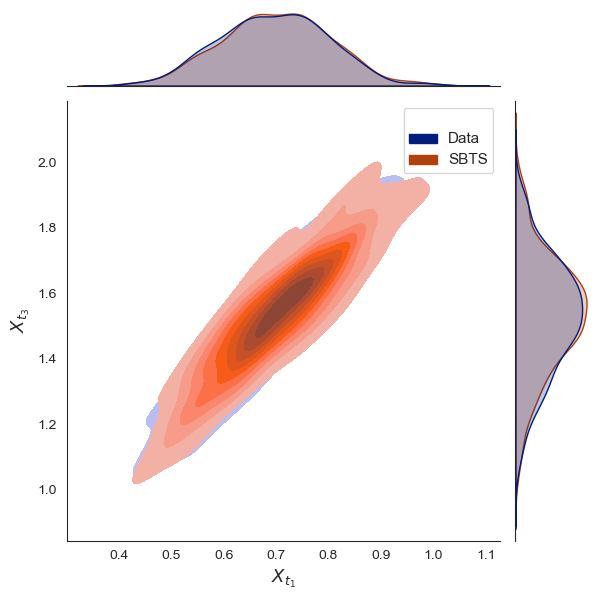

In [6]:
# Add simulated and true time series distributions to dataframe
df_data_SBTS = pd.DataFrame()
df_data_SBTS["X_1"] = X[:500,1].tolist() + simu[:500,1].tolist()
df_data_SBTS["X_2"] = X[:500,2].tolist() + simu[:500,2].tolist()
df_data_SBTS["X_3"] = X[:500,3].tolist() + simu[:500,3].tolist()
df_data_SBTS["type"] = ["Data"]*500 + ["SBTS"]*500

# Plot distribution
sns.set_style("whitegrid")
sns.set_style("white")

# Set pair
x = "X_1"
y = "X_3"

ax = sns.jointplot(
    data=df_data_SBTS,
    x=x, y=y, hue="type", ec='Navy', lw=2, alpha=1, palette="dark", kind="kde", fill=True
)
ax.set_axis_labels(r"$X_{t_1}$", r"$X_{t_3}$", fontsize=13)
ax.ax_joint.legend_.get_title().set_text("")
plt.setp(ax.ax_joint.legend_.get_texts(), fontsize=11)

## 3. Quantiles and Kolmogorov-Smirnov test

In [7]:
df_stats_quantiles = pd.DataFrame(
    columns=[
    "p-value", 
    "5%-quantile data", 
    "5%-quantile SB", 
    "95%-quantile data", 
    "95%-quantile SB"
    ],
    index=[1,2,3]
)

In [8]:
for i in df_stats_quantiles.index:
    
    # Kolmogorov Smirnov test
    df_stats_quantiles['p-value'].loc[i] = kstest(rvs=X[:,i], cdf=simu[:,i])[1]
    
    # Quantiles
    df_stats_quantiles['5%-quantile data'].loc[i] = np.quantile(X[:,i], 0.05)
    df_stats_quantiles['95%-quantile data'].loc[i] = np.quantile(X[:,i], 0.95)
    df_stats_quantiles['5%-quantile SB'].loc[i] = np.quantile(simu[:,i], 0.05)
    df_stats_quantiles['95%-quantile SB'].loc[i] = np.quantile(simu[:,i], 0.95)

In [9]:
df_stats_quantiles

,p-value,5%-quantile data,5%-quantile SB,95%-quantile data,95%-quantile SB
1,0.794664,0.539112,0.534292,0.859133,0.865941
2,0.980263,-0.880132,-0.89163,-0.517089,-0.518242
3,0.99696,1.241113,1.233731,1.820064,1.835535


## 4. Correlation Matrix

In [10]:
data_correlation_matrix = np.corrcoef(X[:,1:].T)
SB_correlation_matrix = np.corrcoef(simu[:,1:].T)

In [11]:
data_correlation_matrix

array([[ 1.        , -0.885643  ,  0.90871303],
       [-0.885643  ,  1.        , -0.94623537],
       [ 0.90871303, -0.94623537,  1.        ]])

In [12]:
SB_correlation_matrix

array([[ 1.        , -0.87412881,  0.89413307],
       [-0.87412881,  1.        , -0.93946882],
       [ 0.89413307, -0.93946882,  1.        ]])

In [13]:
(data_correlation_matrix - SB_correlation_matrix).round(3)

array([[ 0.   , -0.012,  0.015],
       [-0.012,  0.   , -0.007],
       [ 0.015, -0.007,  0.   ]])

# Garch Model

## 1. SBTS diffusion

In [14]:
# Number of time steps and number of samples
M = 1000
N = 60

# Generate Garch time series
alpha_0 = 5.
alpha_1 =  0.4
alpha_2 = 0.1

def Garch_sample(alpha_0, alpha_1, alpha_2):
    
    time_series = list()
    x_next = 0.0
    x_prev = 0.0
    
    for t in range(N+50):
        
        # Diffuse over (for example) 50 time steps to achieve stationarity
        if t>=50:
            time_series.append(x_next)
        
        # Compute volatility
        sigma = np.sqrt(alpha_0 + alpha_1 * x_next**2 + alpha_2 * x_prev**2)
        x_prev = x_next
        x_next = sigma * np.random.normal(scale=0.1)
        
    return [0.0] + time_series

X = np.array([Garch_sample(alpha_0, alpha_1, alpha_2) for i in range(M)])

In [15]:
M, N, X.shape

(1000, 60, (1000, 61))

In [16]:
simu = simulateSB(
    N = N, 
    M = M,
    Data = X, 
    deltati = 7./252., 
    H = 0.2, 
    nbStepsPerDeltati = 100, 
    numberOfSamples = 1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

## 2. Time series paths

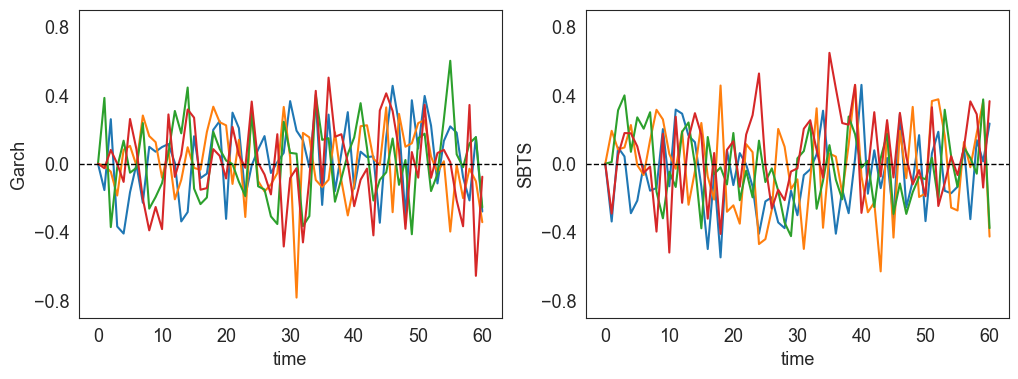

In [17]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Select random paths
for i in range(4):
    j = np.random.randint(len(simu))
    ax[0].plot(X[j], linewidth=1.5)
    ax[1].plot(simu[j], linewidth=1.5)
    
ax[0].axhline(0, linewidth=1, linestyle="--", color='k')
ax[0].set_xlabel('time')
ax[0].set_ylabel('Garch')
ax[0].set_ylim(-0.9, 0.9)
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[0].set_yticks([-0.8, -0.4, 0, 0.4, 0.8])

ax[1].axhline(0, linewidth=1, linestyle="--", color='k')
ax[1].set_xlabel('time')
ax[1].set_ylabel('SBTS')
ax[1].set_ylim(-0.9, 0.9)
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[1].set_yticks([-0.8, -0.4, 0, 0.4, 0.8])

## 3. Kolmogorov-Smirnov test

In [18]:
p_value = [ks_2samp(simu[:,i], X[:,i])[1] for i in range(1, N+1)]

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 [Text(-10.0, 0, '−10'),
  Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60'),
  Text(70.0, 0, '70')])

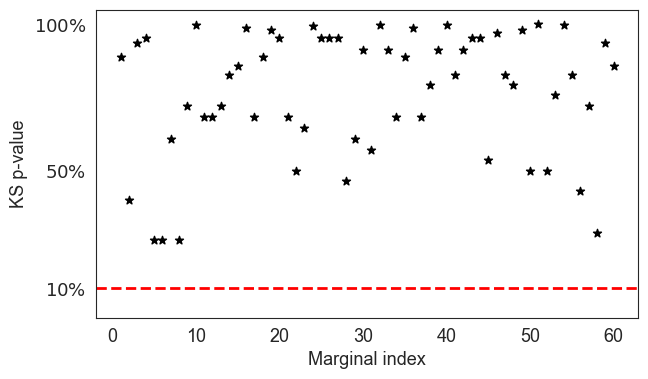

In [19]:
fig = plt.figure(figsize=(7,4))
plt.scatter(list(range(1,N+1)), p_value, color='k', linewidth=1, marker='*')
plt.axhline(0.1, linestyle='--', color='red', linewidth=2)
plt.ylabel("KS p-value", fontsize=13)
plt.xlabel("Marginal index", fontsize=13)
plt.yticks([0.1, 0.5, 1], [r"$10\%$", r"$50\%$", r"$100\%$"], fontsize=13)
plt.ylim(0,1.05)
plt.xticks(fontsize=13)

## 4. Correlation Matrix

([<matplotlib.axis.YTick at 0x26c8a2d5940>,
 [Text(0, -0.1, '$-10\\%$'),
  Text(0, -0.05, '$-5\\%$'),
  Text(0, 0.0, '$0\\%$'),
  Text(0, 0.05, '$5\\%$'),
  Text(0, 0.1, '$10\\%$')])

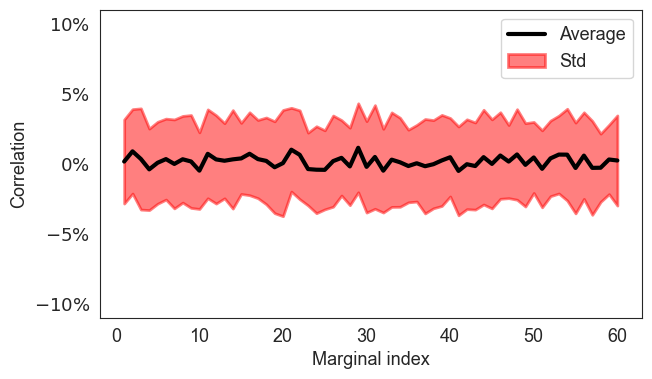

In [20]:
fig = plt.figure(figsize=(7,4))

# compute mean and std
mean = pd.DataFrame(np.corrcoef(X.T)-np.corrcoef(simu.T)).replace(np.nan, 0).mean()[1:].values
std = pd.DataFrame(np.corrcoef(X.T)-np.corrcoef(simu.T)).replace(np.nan, 0).std()[1:].values

# plot
plt.plot(np.arange(1,N+1), mean, color='k', linewidth=3, label='Average')
plt.fill_between(np.arange(1,N+1), mean-std, mean+std, color='r', alpha=0.5, linewidth=2, label="Std")
plt.ylim(-0.11, 0.11)
plt.legend()
plt.tick_params(which='both', width=2)
plt.xticks(fontsize=13)
plt.xlabel("Marginal index", fontsize=13)
plt.ylabel("Correlation", fontsize=13)
plt.yticks([-0.1, -0.05, 0.0, 0.05, 0.1], [r"$-10\%$", r"$-5\%$", r"$0\%$", r"$5\%$", r"$10\%$"], fontsize=13)

## 5. Distribution $(X_{t_1}, X_{t_N})$

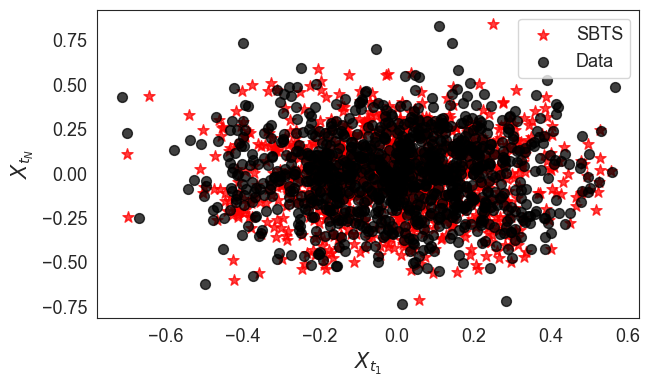

In [21]:
fig = plt.figure(figsize=(7,4))
plt.scatter(simu[:,1], simu[:,N], color='r', alpha=0.75, label="SBTS", marker="*", s=70)
plt.scatter(X[:,1], X[:,N], color='k', alpha=0.75, label="Data", marker="o", s=50)
plt.ylabel(r"$X_{t_{N}}$", fontsize=15)
plt.xlabel(r"$X_{t_{1}}$", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()

# Fractional Brownian Motion

## 1. Simulation

In [22]:
M = 1000
N = 60

# Generate Garch time series
hurst_parameter = 0.2
f = FBM(n=N, hurst=hurst_parameter, length=1, method='daviesharte')

# Generate fBm true samples
X = np.array([(f.fbm()).tolist() for i in range(M)])

In [23]:
M, N, X.shape

(1000, 60, (1000, 61))

In [24]:
simu = simulateSB(
    N = N, 
    M = M,
    Data = X,
    deltati = 7./252.,
    H = 0.1,
    nbStepsPerDeltati = 100,
    numberOfSamples = 1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

## 2. Time series paths

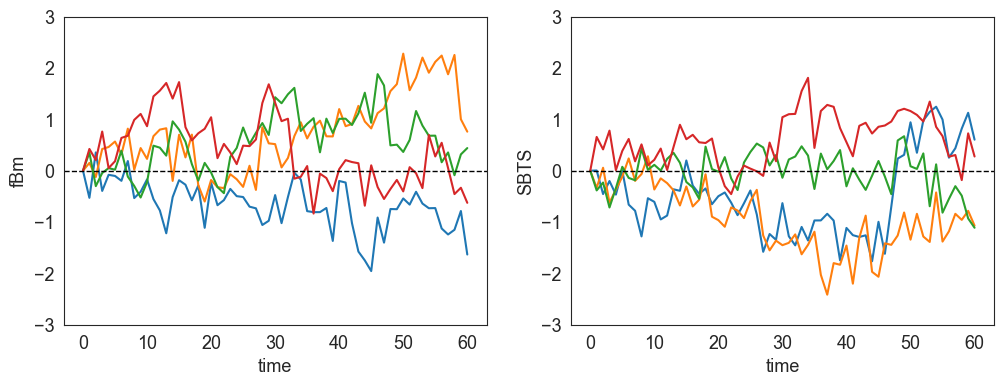

In [25]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Select random paths
for i in range(4):
    ax[0].plot(X[np.random.randint(X.shape[0])], linewidth=1.5)
    ax[1].plot(simu[np.random.randint(simu.shape[0])], linewidth=1.5)
    
ax[0].axhline(0, linewidth=1, linestyle="--", color='k')
ax[0].set_xlabel('time')
ax[0].set_ylabel('fBm')
ax[0].set_ylim(-3, 3)
ax[0].tick_params(axis='both', which='major', labelsize=13)

ax[1].axhline(0, linewidth=1, linestyle="--", color='k')
ax[1].set_xlabel('time')
ax[1].set_ylabel('SBTS')
ax[1].set_ylim(-3, 3)
ax[1].tick_params(axis='both', which='major', labelsize=13)

## 3. Hurst parameter estimation

In [26]:
def hurst_estimation(paths):
    return -np.log((np.diff(paths)**2).sum(axis=1).mean())/(2*np.log(paths.shape[1]-1)) + 0.5

hurst_list = [hurst_estimation(simu[50*i:50*(i+1)]) for i in range(20)]

In [27]:
print(f"Hurst parameters: average = {np.round(np.mean(hurst_list), 3)}, std = {np.round(np.std(hurst_list), 3)}")

Hurst parameters: average = 0.199, std = 0.004


## 4. Covariance Matrix

In [28]:
simu_covar = np.cov(simu.T)
theo_covar = np.zeros((N+1,N+1))
for t in range(N+1):
    for s in range(t,N+1):
        theo_covar[t,s] = 0.5 * (np.power(f.times()[t], 2 * hurst_parameter) + np.power(f.times()[s], 2 * hurst_parameter) 
                                 - np.power(f.times()[s] - f.times()[t], 2 * hurst_parameter))
        theo_covar[s,t] = theo_covar[t,s]

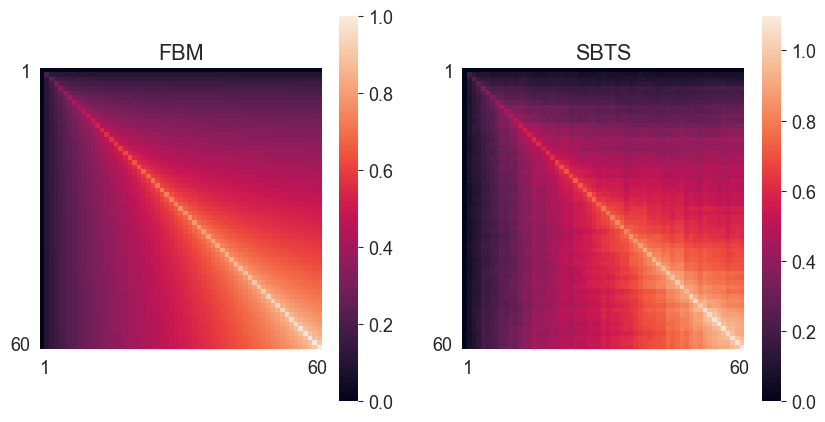

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
hm0 = sns.heatmap(theo_covar,
                 cbar=True,
                 square=True,
                 ax=ax[0])
ax[0].set_title("FBM")
ax[0].set_xticks([1, N], [1, N])
ax[0].set_yticks([1, N], [1, N])
hm1 = sns.heatmap(simu_covar,
                 cbar=True,
                 square=True,
                 ax=ax[1])
ax[1].set_title("SBTS")
ax[1].set_xticks([1, N], [1, N])
ax[1].set_yticks([1, N], [1, N])

## 6. Quadratique variation

In [30]:
def get_X_simu_fbm(N_):
    
    # Generate fBm time series
    hurst_parameter = 0.1
    f = FBM(n=N_, hurst=hurst_parameter, length=1, method='daviesharte')
    X_ = np.array([(f.fbm()).tolist() for i in range(M)])
    
    simu_ = simulateSB(
        N = N_, 
        M = M,
        Data = X_, 
        deltati = 7./252., 
        H = 0.1, 
        nbStepsPerDeltati = 100, 
        numberOfSamples = 500
    )
    
    return X_, simu_

dic_X = {}
dic_simu = {}

for N_ in [30, 60]:
    dic_X[N_], dic_simu[N_] = get_X_simu_fbm(N_)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [31]:
dic_quadratic_variation = {}
for N_ in dic_X.keys():
    simu_ = dic_simu[N_]
    X_ = dic_X[N_]
    quadratic_var_simu = np.power(np.diff(simu_), 2).sum(axis=1)
    quadratic_var_X = np.power(np.diff(X_), 2).sum(axis=1)
    dic_quadratic_variation[N_] = {
        "fBm": quadratic_var_X,
        "SBTS": quadratic_var_simu
    }

### Case: N=30

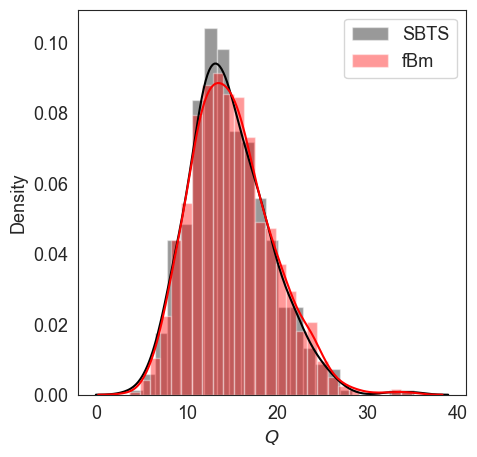

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.set_style("white")
sns.distplot(dic_quadratic_variation[30]["SBTS"], ax=ax, label="SBTS", color='k', kde=True)
sns.distplot(dic_quadratic_variation[30]["fBm"], ax=ax, label="fBm", color='r', kde=True)
ax.set_xlabel(r"$Q$")
ax.legend()

### Case: N=60

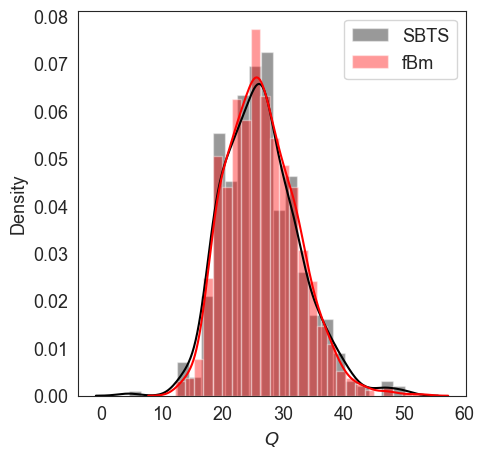

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.set_style("white")
sns.distplot(dic_quadratic_variation[60]["SBTS"], ax=ax, label="SBTS", color='k', kde=True)
sns.distplot(dic_quadratic_variation[60]["fBm"], ax=ax, label="fBm", color='r', kde=True)
ax.set_xlabel(r"$Q$")
ax.legend()

# Real Data: AAPL

## 1. SBTS diffusion

In [34]:
# Download data using Yahoo Finance API
start_date = "2010-01-01"
end_date = "2020-01-30"
data = pdr.get_data_yahoo("AAPL", start=start_date, end=end_date)

# Take rolling window to create many samples of apple time series
N = 60
X = np.array([data["Adj Close"].values[i:i+N+1]/data["Adj Close"].values[i] for i in range(len(data)-N)])
M = len(X)

# Get log returns
log_returns = np.zeros((M, N+1))
log_returns[:,1:] = np.diff(np.log(X), axis=1)

[*********************100%***********************]  1 of 1 completed


In [35]:
log_returns.shape, X.shape

((2475, 61), (2475, 61))

In [36]:
# SBTS diffusion of log returns
simu_log_returns = simulateSB(
    N = N, 
    M = log_returns.shape[0],
    Data = log_returns,
    deltati = 2./252.,
    H = 0.05, 
    nbStepsPerDeltati = 100, 
    numberOfSamples = 1000
)

# Convert log returns
simu = np.exp(simu_log_returns.cumsum(axis=1))

  0%|          | 0/1000 [00:00<?, ?it/s]

## 2. Time series paths

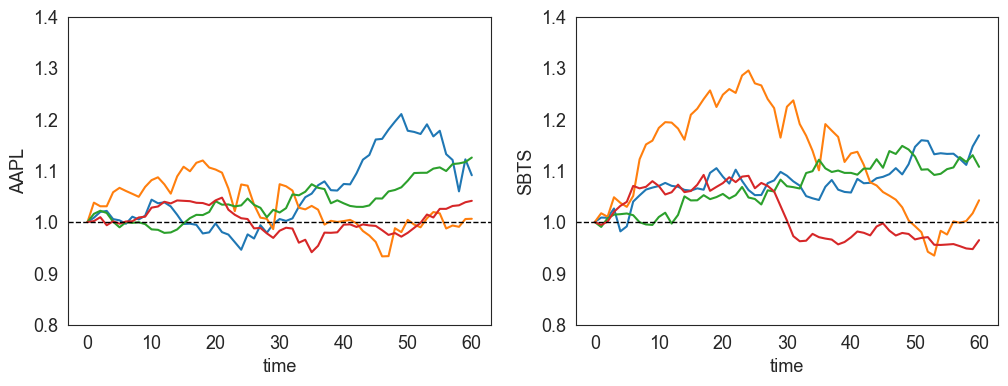

In [37]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Select random paths
for i in range(4):
    ax[0].plot(X[np.random.randint(len(X))], linewidth=1.5)
    ax[1].plot(simu[np.random.randint(len(simu))], linewidth=1.5)
    
ax[0].axhline(1, linewidth=1, linestyle="--", color='k')
ax[1].axhline(1, linewidth=1, linestyle="--", color='k')

ax[0].set_xlabel('time')
ax[0].set_ylabel('AAPL')
ax[0].set_ylim(0.8, 1.4)
ax[0].tick_params(axis='both', which='major', labelsize=13)

ax[1].set_xlabel('time')
ax[1].set_ylabel('SBTS')
ax[1].set_ylim(0.8, 1.4)
ax[1].tick_params(axis='both', which='major', labelsize=13)

## 3. Covariance matrix

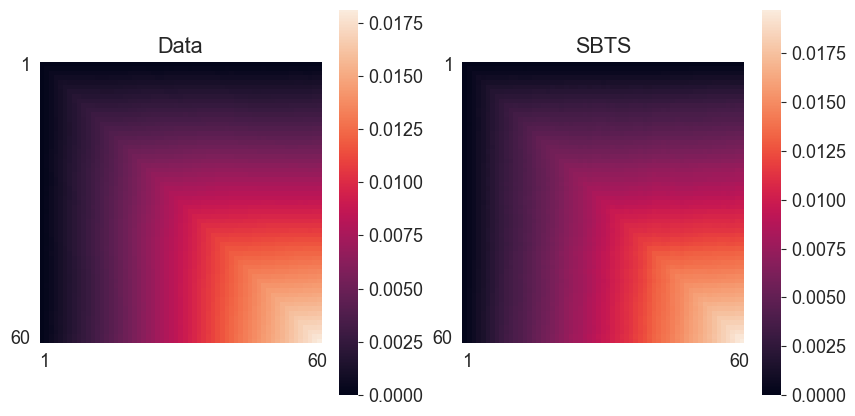

In [38]:
X_covar = np.cov(X.T)
simu_covar = np.cov(simu.T)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
hm0 = sns.heatmap(X_covar,
                 cbar=True,
                 square=True,
                 ax=ax[0])
ax[0].set_title("Data")
ax[0].set_xticks([1, N], [1, N])
ax[0].set_yticks([1, N], [1, N])
hm1 = sns.heatmap(simu_covar,
                 cbar=True,
                 square=True,
                 ax=ax[1])
ax[1].set_title("SBTS")
ax[1].set_xticks([1, N], [1, N])
ax[1].set_yticks([1, N], [1, N])
plt.show()

## 4. Quadratic variation

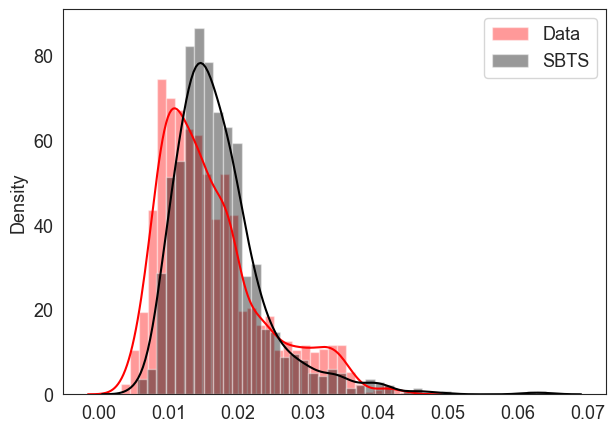

In [39]:
quadratic_var_simu = np.power(np.diff(np.array(simu)[:,]), 2).sum(axis=1)
quadratic_var_X = np.power(np.diff(X[:,]), 2).sum(axis=1)
fig = plt.figure(figsize=(7,5))
sns.distplot(quadratic_var_X, label="Data", color='r')
sns.distplot(quadratic_var_simu, label="SBTS", color='k')
plt.legend()

## 5. Tail distribution of returns

In [40]:
M_max = min(1000, len(simu), len(X)) # used to select a mini-batch of paths

# Compute retruns
simu_returns = np.abs(np.array(simu)[:,-1] - np.array(simu)[:,0])
X_returns = np.abs(np.array(X)[:,-1] - np.array(X)[:,0])
gaussian_returns = np.abs(np.random.normal(loc=np.mean(X_returns), scale=np.std(X_returns), size=M_max))

<Figure size 700x500 with 0 Axes>

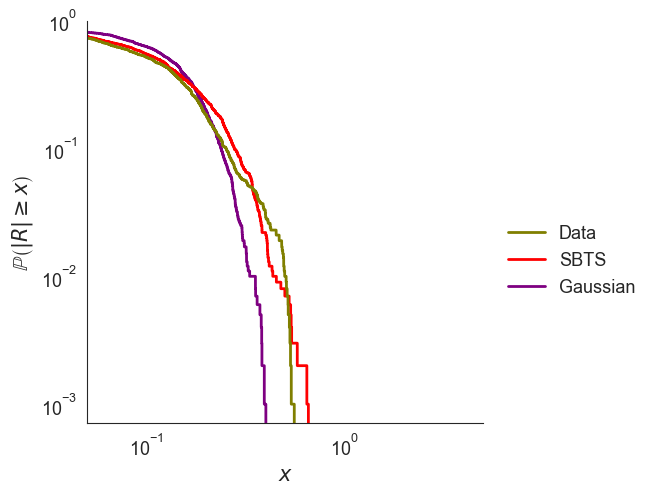

In [41]:
fig = plt.figure(figsize=(7,5))
df_data_plot = pd.DataFrame()
df_data_plot["returns"] = X_returns[:M_max].tolist() + simu_returns[:M_max].tolist() + gaussian_returns.tolist()
df_data_plot["Legend"] = ["Data"] * M_max + ["SBTS"] * M_max + ["Gaussian"] * M_max
ax = sns.displot(data=df_data_plot, x="returns", hue="Legend", complementary=True, kind="ecdf", palette="brg_r", linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"$\mathbb{P}\left(|R| \geq x\right)$", fontsize=15)
plt.xlabel(r"$x$", fontsize=15)
plt.xlim(0.05,5)
ax._legend.get_title().set_text("")

In [42]:
kurtosis(gaussian_returns), kurtosis(simu_returns), kurtosis(X_returns)

(-0.23474133460339264, 1.5856791343905012, 1.9610941450724697)

# Run SBTS to store data for deep hedging

In [45]:
Path("../data/").mkdir(parents=True, exist_ok=True)

if os.path.exists("../data/data_deephedging.npz"):
    
    print("data already exists")
    
else:

    simu_log_returns = simulateSB(
        N = N, 
        M = log_returns.shape[0],
        Data = log_returns,
        deltati = 2./252.,
        H = 0.05, 
        nbStepsPerDeltati = 100, 
        numberOfSamples = 10000
    )

    simu = np.exp(simu_log_returns.cumsum(axis=1))
    
    np.savez_compressed("../data/data_deephedging.npz", X=X, simu=simu)

data already exists


# Minst Handwritten digits

In [46]:
# load dataset
(trainX, _), (_, _) = mnist.load_data()

## 1. Static images

In [47]:
M = 10000
N = 1
NbPixels = trainX.shape[1]
deltati = 1./252.

TimeSeries = np.zeros((M, N+1, NbPixels, NbPixels))
TimeSeries[:,1,:,:] = trainX[:M,:,:]/255/10 - 0.05 # Normalization to avoid numerical issues

In [48]:
TimeSeries.min(), TimeSeries.max()

(-0.05, 0.05)

### SBTS diffusion

In [49]:
TimeSeriesFlat = TimeSeries.reshape(M, N+1, -1)
numberOfSamples = 16

simulator = SBTimeSeries.SchrodingerBridge(N, M, NbPixels**2, TimeSeriesFlat)
simuTimeSeriesFlat = np.empty((numberOfSamples, N+1, NbPixels**2))
for i in tqdm(range(numberOfSamples)):
    images = np.array(simulator.SimulateKernelVectorized(50, 1.1, 1./252.))
    simuTimeSeriesFlat[i] = images

simuTimeSeries = simuTimeSeriesFlat.reshape(numberOfSamples, N+1, NbPixels, NbPixels)

  0%|          | 0/16 [00:00<?, ?it/s]

### True images versus SBTS

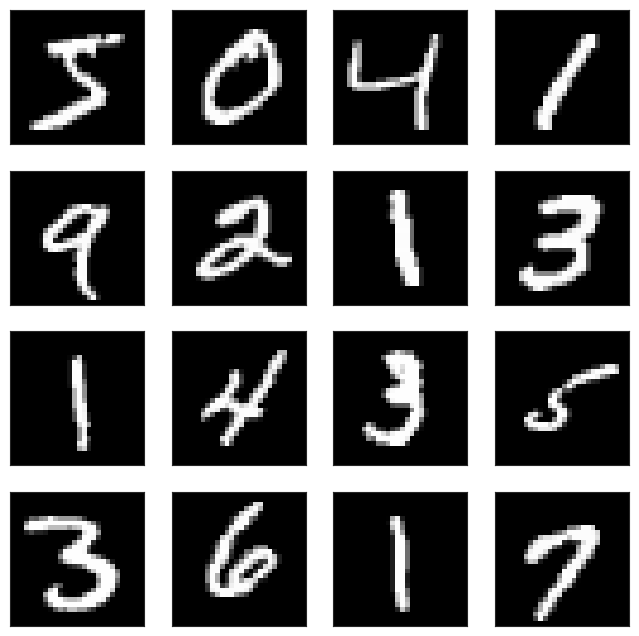

In [50]:
fig, ax = plt.subplots(4, 4, figsize=(8,8))

for i in range(4):
    for j in range(4):
        ax[i,j].imshow((TimeSeries[i*4 + j,1,:,:]+0.05)*10*255, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

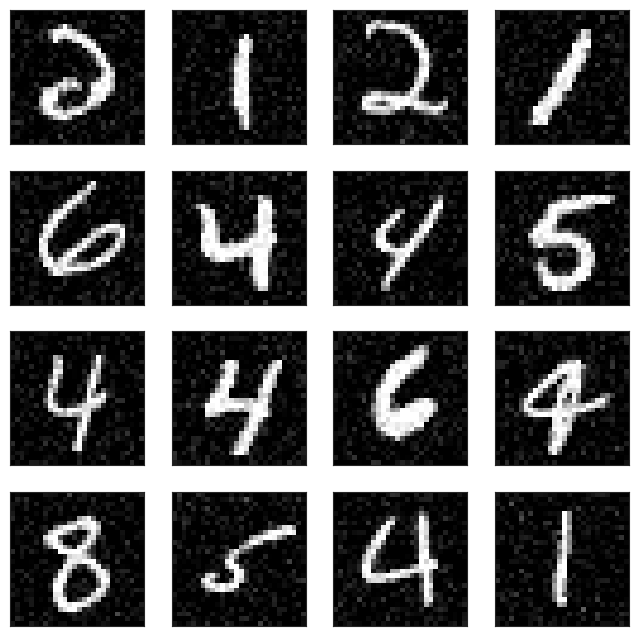

In [51]:
fig, ax = plt.subplots(4, 4, figsize=(8,8))

for i in range(4):
    for j in range(4):
        ax[i,j].imshow((simuTimeSeries[i*4+j,1,:,:]+0.05)*10*255, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

## 2. Time series: example 1

In [65]:
M = 1000
N = 6
NbPixels = 28
NbPixels_filtred = 12

# Define transaltion marix
translation = np.zeros((NbPixels_filtred, NbPixels_filtred))
for i in range(NbPixels_filtred):
    for j in range(NbPixels_filtred):
        if j==i+1:
            translation[i,j] = 1

# True samples
TimeSeries = np.zeros((M, N+1, NbPixels_filtred, NbPixels_filtred))

for n in tqdm(range(M)):
    k = np.random.randint(len(trainX))
    image = trainX[k]
    filtred_image = np.zeros((NbPixels//2, NbPixels//2))
    for i in range(NbPixels//2):
        for j in range(NbPixels//2):
            filtred_image[i,j] = 255 if image[2*i:2*(i+1), 2*j:2*(j+1)].max() > 150 else 0
    filtred_image = filtred_image[1:-1, 1:-1]
    TimeSeries[n,1,:,:] = filtred_image

# Normalisation
TimeSeries[:,1,:,:] = TimeSeries[:,1,:,:]/255

# Define time series
for i in range(M):
    TimeSeries[i,2,:,:] = TimeSeries[i,1,:,:].T
    TimeSeries[i,3,:,:] = np.dot(TimeSeries[i,2,:,:], translation)
    TimeSeries[i,4,:,:] = np.dot(TimeSeries[i,3,:,:], translation)
    TimeSeries[i,5,:,:] = np.dot(TimeSeries[i,4,:,:], translation)
    TimeSeries[i,6,:,:] = np.dot(TimeSeries[i,5,:,:], translation)

TimeSeries -= 0.5

  0%|          | 0/1000 [00:00<?, ?it/s]

In [66]:
TimeSeriesFlat = TimeSeries.reshape(M, N+1, -1)
numberOfSamples = 1

simulator = SBTimeSeries.SchrodingerBridge(N, M, NbPixels_filtred**2, TimeSeriesFlat)
simuTimeSeriesFlat = np.empty((numberOfSamples, N+1, NbPixels_filtred**2))

for i in tqdm(range(numberOfSamples)):
    images = simulator.SimulateKernelVectorized(50, 1.1, 14./252.)
    simuTimeSeriesFlat[i] = images
simuTimeSeries = simuTimeSeriesFlat.reshape(numberOfSamples, N+1, NbPixels_filtred, NbPixels_filtred)

  0%|          | 0/1 [00:00<?, ?it/s]

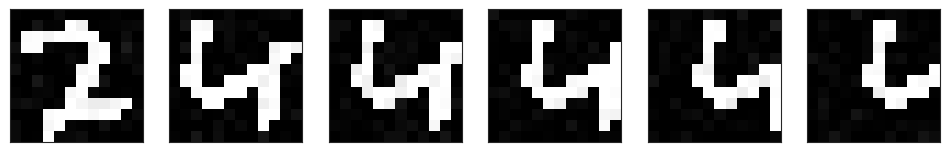

In [67]:
fig, ax = plt.subplots(1, 6, figsize=(12,2))

for i in range(N):
        ax[i].imshow((simuTimeSeries[0,i+1,:,:]+0.5)*255, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        ax[i].set_xticks([])
        ax[i].set_yticks([])

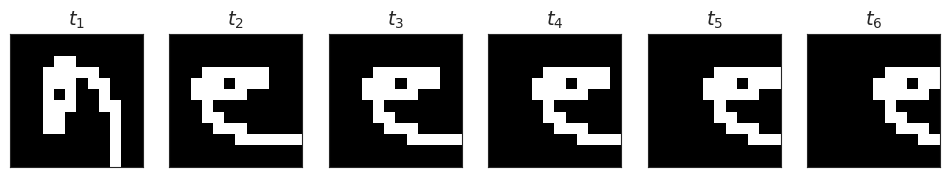

In [68]:
fig, ax = plt.subplots(1, 6, figsize=(12,2))
k = np.random.randint(M)
for i in range(N):
        ax[i].imshow((TimeSeries[k,i+1,:,:]+0.5)*255, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(fr"$t_{i+1}$", fontsize=14)

## 3. Time series: example 2

In [69]:
M = 1000
N = 6
NbPixels = 28
NbPixels_filtred = 12

final_image = np.zeros((NbPixels_filtred,NbPixels_filtred))

for i in range(NbPixels_filtred):
    for j in range(NbPixels_filtred):
        if (i*(NbPixels_filtred-1) + j) % 2 == 1:
            final_image[i,j] = 1

TimeSeries += 0.5
for i in range(N):
    for j in range(1, N):
        TimeSeries[i,j+1,:,:] = 0.5*TimeSeries[i,j,:,:] + 0.5*final_image
TimeSeries -= 0.5

In [70]:
TimeSeriesFlat = TimeSeries.reshape(M, N+1, -1)
numberOfSamples = 1

simulator = SBTimeSeries.SchrodingerBridge(N, M, NbPixels_filtred**2, TimeSeriesFlat)
simuTimeSeriesFlat = np.empty((numberOfSamples, N+1, NbPixels_filtred**2))

for i in tqdm(range(numberOfSamples)):
    images = simulator.SimulateKernelVectorized(50, 1.1, 14./252.)
    simuTimeSeriesFlat[i] = images
simuTimeSeries = simuTimeSeriesFlat.reshape(numberOfSamples, N+1, NbPixels_filtred, NbPixels_filtred)

  0%|          | 0/1 [00:00<?, ?it/s]

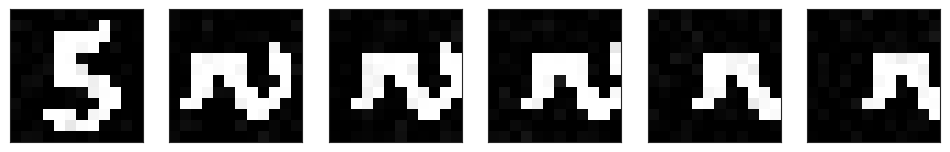

In [71]:
fig, ax = plt.subplots(1, 6, figsize=(12,2))

for i in range(N):
        ax[i].imshow((simuTimeSeries[0,i+1,:,:]+0.5)*255, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        ax[i].set_xticks([])
        ax[i].set_yticks([])

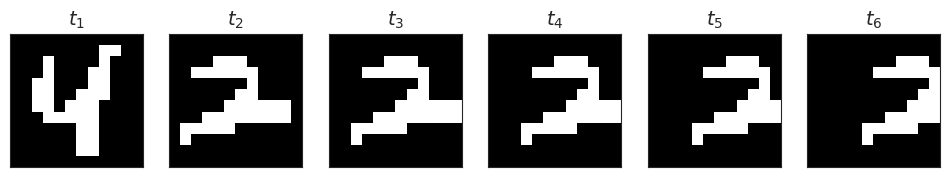

In [72]:
fig, ax = plt.subplots(1, 6, figsize=(12,2))
k = np.random.randint(M)
for i in range(N):
        ax[i].imshow((TimeSeries[k,i+1,:,:]+0.5)*255, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(fr"$t_{i+1}$", fontsize=14)